<a href="https://colab.research.google.com/github/nova-zl504/wasserstein-GP-minist/blob/master/wan_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = (images + 1.0) / 2.0 * 255
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    plt.show()
    return

# Dataset

11493376/11490434 [==============================] - 0s 0us/step


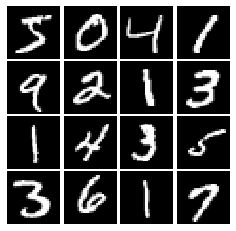

In [2]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = (X.astype(np.float32)/255 * 2.0) - 1.0
        X = X.reshape((X.shape[0], 28, 28, 1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

# show a batch
mnist = MNIST(batch_size=16, shuffle=True) 
show_images(mnist.X[:16])

# Leaky Relu

In [0]:
def leaky_relu(X, alpha=1e-2):
  return tf.maximum(X * alpha, X)

# Pixel Normalization

In [0]:
def pixel_norm(x, epsilon=1e-8):
    with tf.variable_scope('PixelNorm'):
        return x * tf.rsqrt(tf.reduce_mean(tf.square(x), axis=1, keepdims=True) + epsilon)

# Discriminator

In [0]:
def discriminator(images):
  
  with tf.variable_scope('discriminator'):
    net = tf.identity(images, name='input')
    
    net = tf.layers.conv2d(net, filters=32, kernel_size=5, strides=1,
                          padding='VALID', name='conv.1')
    net = pixel_norm(net)
    net = leaky_relu(net)
    
    net = tf.layers.max_pooling2d(net, 2, 2)
    
    net = tf.layers.conv2d(net, filters=64, kernel_size=5, strides=1,
                          padding='VALID', name='conv.2')
    net = pixel_norm(net)
    net = leaky_relu(net)
    
    net = tf.layers.max_pooling2d(net, 2, 2)
    
    net = tf.layers.flatten(net)
    net = tf.layers.dense(net, 4 * 4 * 64, name='dense.3')
    net = pixel_norm(net)
    net = leaky_relu(net)
    
    net = tf.layers.dense(net, 1, name='dense.4')
    #net = tf.nn.softmax(net)
    
    return tf.identity(net, name='output')

# Generator

In [0]:
def generator(Z):
  with tf.variable_scope('generator'):
    net = tf.identity(Z, name='input')
    
    net = tf.layers.dense(net, 7*7*8)
    net = pixel_norm(net)
    net = tf.nn.relu(net)
    
    net = tf.reshape(net, shape=(tf.shape(Z)[0], 7, 7, 8))
        
    net = tf.layers.conv2d_transpose(net, filters=64, kernel_size=1,
                                    strides=1, padding='SAME')
    net = pixel_norm(net)
    net = tf.nn.relu(net)
    
    for i in range(2):
      residual = net
      net = tf.layers.conv2d(net, filters=64*6, kernel_size=1,
                                    strides=1, padding='VALID')
      net = pixel_norm(net)
      net = tf.nn.relu(net)
      
      net = tf.layers.separable_conv2d(net, filters=64*6, kernel_size=3,
                                      strides=1, padding='SAME')
      net = pixel_norm(net)
      net = tf.nn.relu(net)
      
      net = tf.layers.conv2d(net, filters=64, kernel_size=1,
                                    strides=1, padding='VALID')

      net = net + residual
    
    net = tf.layers.conv2d_transpose(net, filters=32, kernel_size=4,
                                    strides=2, padding='SAME')
    net = pixel_norm(net)
    net = tf.nn.relu(net)
    
    net = tf.layers.conv2d_transpose(net, filters=1, kernel_size=4,
                                    strides=2, padding='SAME',
                                    activation='tanh')
    
    return tf.identity(net, name='output')

In [0]:
def losses(fake_images, real_images, fake_logits, real_logits, alpha):
  differences = fake_images - real_images
  interpolates = real_images + (alpha * differences)
  gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]
  slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]) + 1e-10)
  gradient_penalty = tf.square(slopes - 1.)
  G_loss = tf.reduce_mean(tf.nn.softplus(-fake_logits))
  D_loss = tf.reduce_mean(tf.nn.softplus(fake_logits) - tf.nn.softplus(real_logits)) + 10.0 * tf.reduce_mean(gradient_penalty)
  return G_loss, D_loss


In [0]:
def G_logistic_nonsaturating(fake_scores): # pylint: disable=unused-argument
    loss = tf.nn.softplus(-fake_scores)  # -log(logistic(fake_scores_out))
    return tf.reduce_mean(loss)

def D_logistic_simplegp(fake_scores, real_scores, fake_images, r1_gamma=10.0, r2_gamma=0.0):
    #fake_scores = autosummary('Loss/scores/real', fake_scores)
    #real_scores = autosummary('Loss/scores/fake', real_scores)

    loss = tf.nn.softplus(fake_scores)  # -log(1 - logistic(fake_scores))
    loss += tf.nn.softplus(-real_scores)  # -log(logistic(real_scores_out)) # temporary pylint workaround # pylint: disable=invalid-unary-operand-type

    if r1_gamma != 0.0:
        with tf.name_scope('R1Penalty'):
            real_loss = tf.reduce_sum(real_scores)
            real_grads = tf.gradients(real_loss, [real_scores])[0]
            print("*", real_grads.shape)
            r1_penalty = tf.reduce_sum(tf.square(real_grads), axis=[1])
            #r1_penalty = autosummary('Loss/r1_penalty', r1_penalty)
        loss += r1_penalty * (r1_gamma * 0.5)

    if r2_gamma != 0.0:
        with tf.name_scope('R2Penalty'):
            fake_loss = tf.reduce_sum(fake_scores)
            fake_grads = tf.gradients(fake_loss, [fake_images])[0]
            r2_penalty = tf.reduce_sum(tf.square(fake_grads), axis=[1])
            #r2_penalty = autosummary('Loss/r2_penalty', r2_penalty)
        loss += r2_penalty * (r2_gamma * 0.5)
    return loss
  
def loss_simple_gp(fake_images, real_images, fake_logits, real_logits, alpha):
  return G_logistic_nonsaturating(fake_logits), D_logistic_simplegp(fake_logits, real_logits, fake_images)

# Build the Whole Graph

In [38]:
epoch_count = 100
batch_size = 256

learning_rate=1e-4
beta1=0.5

CHECKPOINTS_DIR='checkpoints'

tf.reset_default_graph()

real_images = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28, 1)
                             , name='real_images')
alpha = tf.placeholder(dtype=tf.float32, shape=(None, 1, 1, 1))
# noise will be fed into generator
noise = tf.random_uniform((batch_size, 128), minval=-1, maxval=1)
# fake images 
fake_images = generator(noise)

print(fake_images.shape)

with tf.variable_scope('') as scope:
  real_logits = discriminator(real_images)
  scope.reuse_variables()
  fake_logits = discriminator(fake_images)
  G_loss, D_loss = losses(fake_images, real_images, fake_logits, real_logits, alpha)
  #G_loss, D_loss = loss_simple_gp(fake_images, real_images, fake_logits, real_logits, alpha)



D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
  
#G_loss, D_loss = least_loss(fake_logits, real_logits)

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')


D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

(256, 28, 28, 1)


#Train

epoch 1


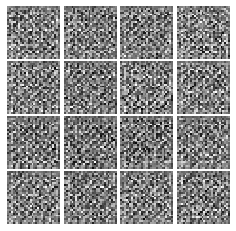

iteration: 234 - D_loss: -33.67974090576172 - G_loss: 0.7140812873840332
epoch 2


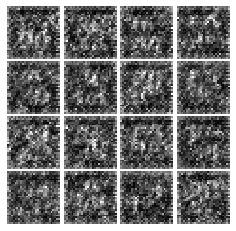

iteration: 234 - D_loss: -30.041797637939453 - G_loss: 0.32060694694519043
epoch 3


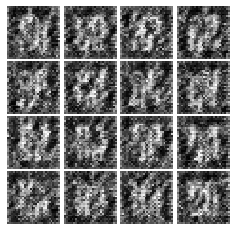

iteration: 234 - D_loss: -32.73228454589844 - G_loss: 0.3810287117958069
epoch 4


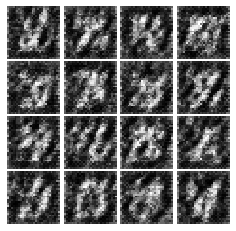

iteration: 234 - D_loss: -34.783897399902344 - G_loss: 0.20647184550762177
epoch 5


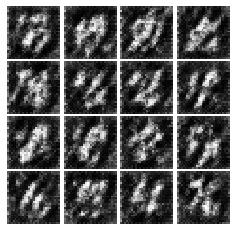

iteration: 234 - D_loss: -37.519771575927734 - G_loss: 0.2231849581003189
epoch 6


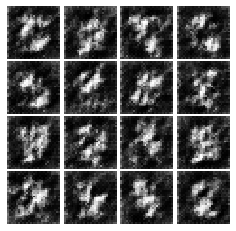

iteration: 234 - D_loss: -38.5181884765625 - G_loss: 0.19704574346542358
epoch 7


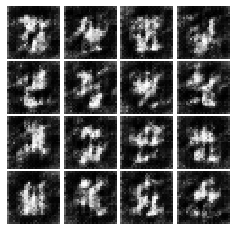

iteration: 234 - D_loss: -39.70857620239258 - G_loss: 0.5343695878982544
epoch 8


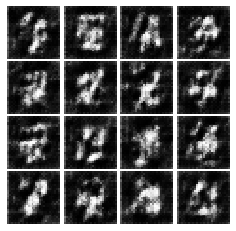

iteration: 234 - D_loss: -43.376380920410156 - G_loss: 0.21986649930477142
epoch 9


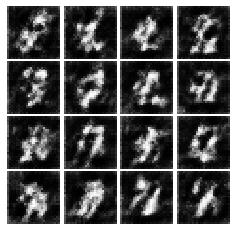

iteration: 234 - D_loss: -45.946434020996094 - G_loss: 0.005065078381448984
epoch 10


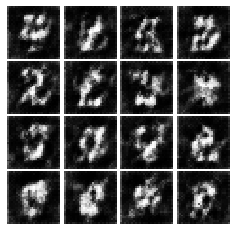

iteration: 234 - D_loss: -50.572879791259766 - G_loss: 0.40356144309043884
epoch 11


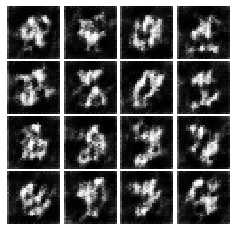

iteration: 234 - D_loss: -54.224308013916016 - G_loss: 1.0337153673171997
epoch 12


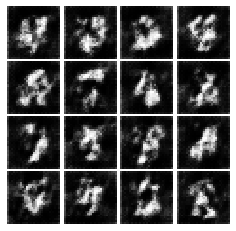

iteration: 234 - D_loss: -53.67286682128906 - G_loss: 0.03360017389059067
epoch 13


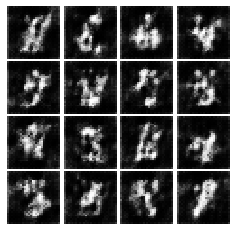

iteration: 234 - D_loss: -55.051048278808594 - G_loss: 0.04986540973186493
epoch 14


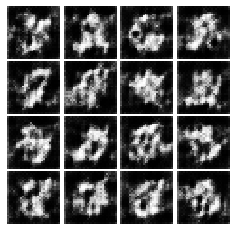

iteration: 234 - D_loss: -54.01987838745117 - G_loss: 0.0026113686617463827
epoch 15


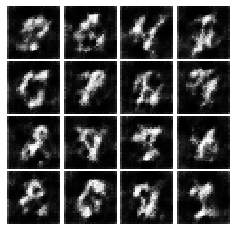

iteration: 234 - D_loss: -60.89482879638672 - G_loss: 0.07114514708518982
epoch 16


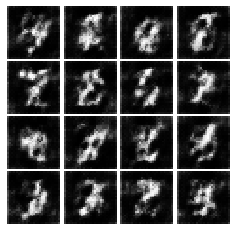

iteration: 234 - D_loss: -58.9766731262207 - G_loss: 0.11381953954696655
epoch 17


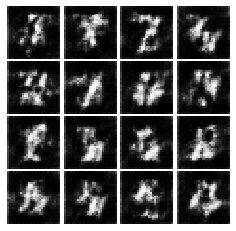

iteration: 234 - D_loss: -61.705562591552734 - G_loss: 0.01848897896707058
epoch 18


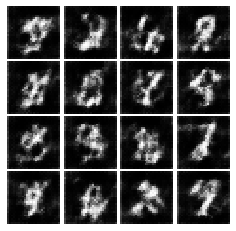

iteration: 234 - D_loss: -64.70823669433594 - G_loss: 0.016692664474248886
epoch 19


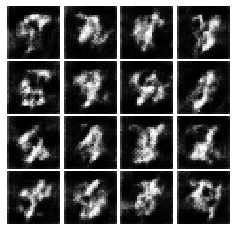

iteration: 234 - D_loss: -64.02852630615234 - G_loss: 0.00043603425729088485
epoch 20


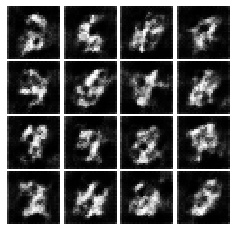

iteration: 234 - D_loss: -71.09915924072266 - G_loss: 0.2119852900505066
epoch 21


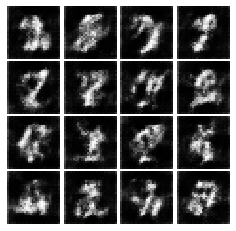

iteration: 234 - D_loss: -73.7144775390625 - G_loss: 0.17746427655220032
epoch 22


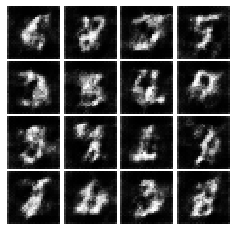

iteration: 234 - D_loss: -72.01051330566406 - G_loss: 0.0048592654056847095
epoch 23


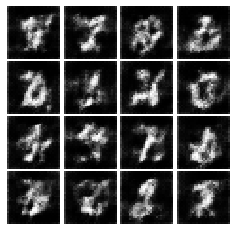

iteration: 234 - D_loss: -71.79499816894531 - G_loss: 0.1295309066772461
epoch 24


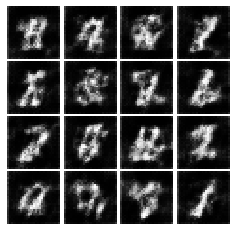

iteration: 234 - D_loss: -73.61184692382812 - G_loss: 4.4187413550389465e-06
epoch 25


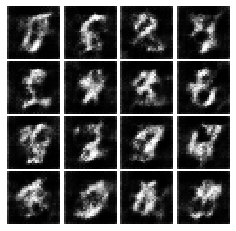

iteration: 234 - D_loss: -73.58273315429688 - G_loss: 0.009509953670203686
epoch 26


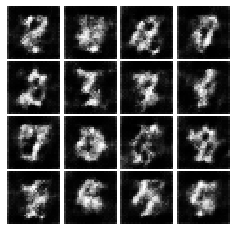

iteration: 234 - D_loss: -73.40544891357422 - G_loss: 0.0002772515290416777
epoch 27


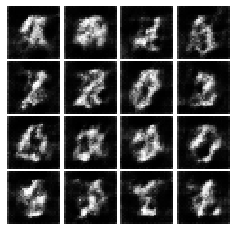

iteration: 234 - D_loss: -79.98045349121094 - G_loss: 0.0036589044611901045
epoch 28


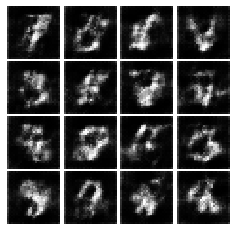

iteration: 234 - D_loss: -76.49510192871094 - G_loss: 0.0005070398328825831
epoch 29


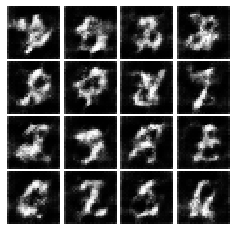

iteration: 234 - D_loss: -75.38615417480469 - G_loss: 7.962769450386986e-05
epoch 30


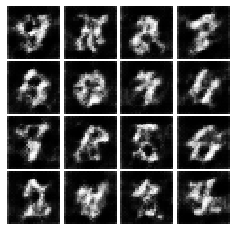

iteration: 234 - D_loss: -77.28044128417969 - G_loss: 0.0001924038224387914
epoch 31


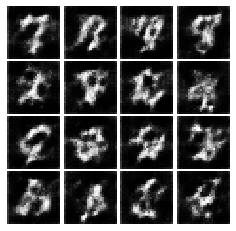

iteration: 234 - D_loss: -88.58523559570312 - G_loss: 0.0032217102125287056
epoch 32


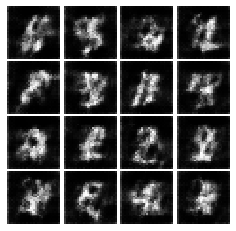

iteration: 234 - D_loss: -84.16244506835938 - G_loss: 8.625838745501824e-06
epoch 33


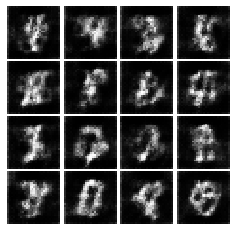

iteration: 234 - D_loss: -87.22185516357422 - G_loss: 0.0027017234824597836
epoch 34


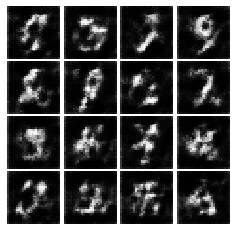

iteration: 234 - D_loss: -75.59346771240234 - G_loss: 0.0012081757886335254
epoch 35


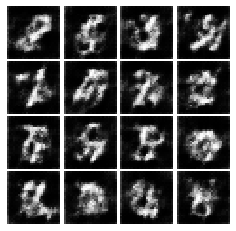

iteration: 234 - D_loss: -72.18620300292969 - G_loss: 1.7360243873554282e-05
epoch 36


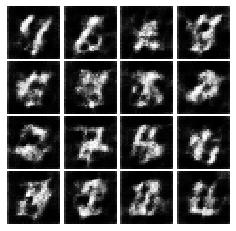

iteration: 234 - D_loss: -74.34915924072266 - G_loss: 7.319380301851197e-07
epoch 37


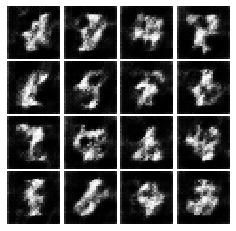

iteration: 234 - D_loss: -77.8865966796875 - G_loss: 3.2135895366991463e-07
epoch 38


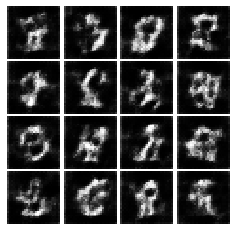

iteration: 234 - D_loss: -83.99773406982422 - G_loss: 0.2244483381509781
epoch 39


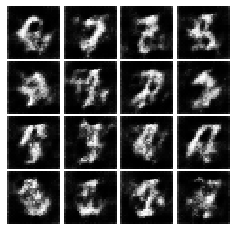

iteration: 234 - D_loss: -82.29315185546875 - G_loss: 1.928271376527846e-05
epoch 40


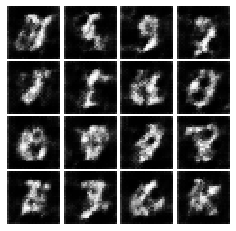

iteration: 234 - D_loss: -83.10780334472656 - G_loss: 0.0021115492563694715
epoch 41


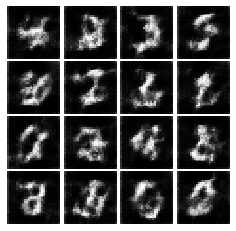

iteration: 234 - D_loss: -81.84768676757812 - G_loss: 4.225831617077347e-06
epoch 42


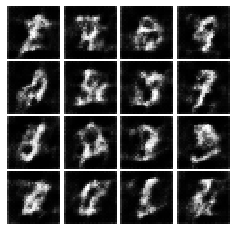

iteration: 234 - D_loss: -78.87366485595703 - G_loss: 2.768624199234182e-06
epoch 43


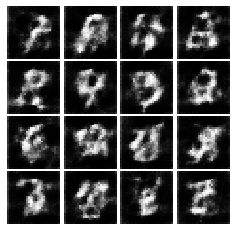

iteration: 234 - D_loss: -79.45450592041016 - G_loss: 1.3101739568810444e-05
epoch 44


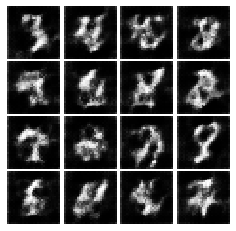

iteration: 234 - D_loss: -81.65461730957031 - G_loss: 0.00504771014675498
epoch 45


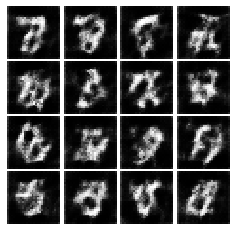

iteration: 234 - D_loss: -83.55699157714844 - G_loss: 0.0012960225576534867
epoch 46


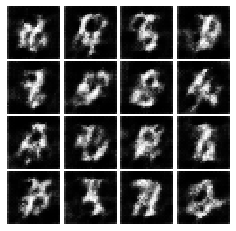

iteration: 234 - D_loss: -89.77192687988281 - G_loss: 0.00210787495598197
epoch 47


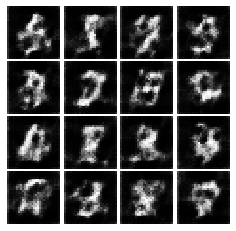

iteration: 234 - D_loss: -77.7186050415039 - G_loss: 1.0860736665563309e-07
epoch 48


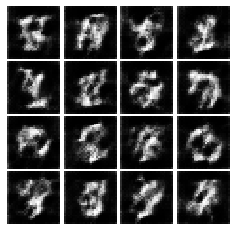

iteration: 234 - D_loss: -88.52208709716797 - G_loss: 0.0854678601026535
epoch 49


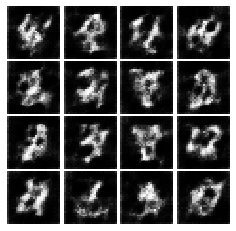

iteration: 234 - D_loss: -92.2159194946289 - G_loss: 0.41070181131362915
epoch 50


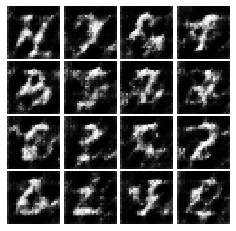

iteration: 234 - D_loss: -69.35804748535156 - G_loss: 0.026816103607416153
epoch 51


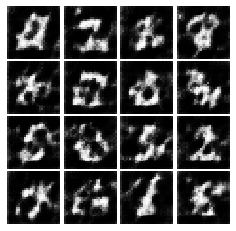

iteration: 234 - D_loss: -81.49821472167969 - G_loss: 0.17912337183952332
epoch 52


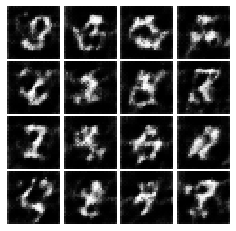

iteration: 234 - D_loss: -80.37104034423828 - G_loss: 0.0051644789054989815
epoch 53


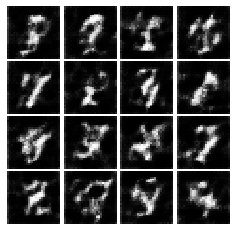

iteration: 234 - D_loss: -70.27533721923828 - G_loss: 0.00039782599196769297
epoch 54


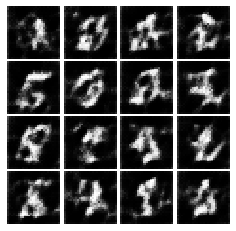

iteration: 234 - D_loss: -71.93447875976562 - G_loss: 0.0005628977669402957
epoch 55


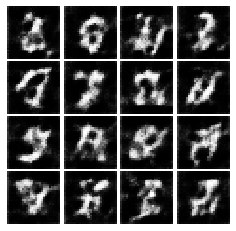

iteration: 234 - D_loss: -71.5107650756836 - G_loss: 2.100099720792059e-07
epoch 56


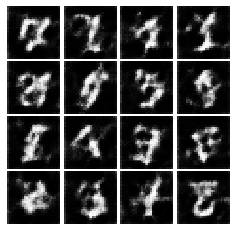

iteration: 234 - D_loss: -82.1064682006836 - G_loss: 0.09814909845590591
epoch 57


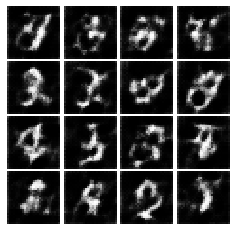

iteration: 234 - D_loss: -79.70182800292969 - G_loss: 0.06351429969072342
epoch 58


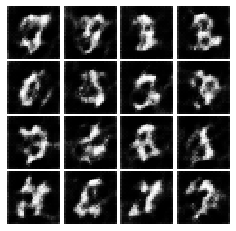

iteration: 234 - D_loss: -75.520263671875 - G_loss: 4.0651116250955965e-07
epoch 59


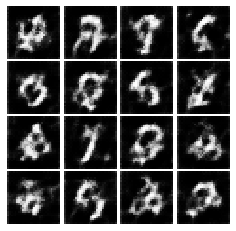

iteration: 234 - D_loss: -71.85003662109375 - G_loss: 9.767211849975865e-06
epoch 60


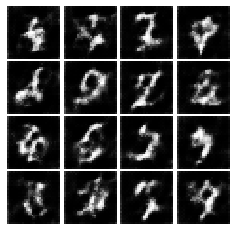

iteration: 234 - D_loss: -70.3236083984375 - G_loss: 0.14957816898822784
epoch 61


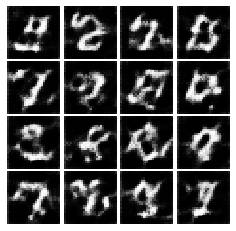

iteration: 234 - D_loss: -75.8462142944336 - G_loss: 0.2719784080982208
epoch 62


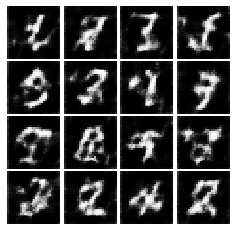

iteration: 234 - D_loss: -76.01312255859375 - G_loss: 2.7004666947050282e-08
epoch 63


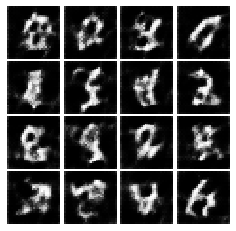

iteration: 234 - D_loss: -78.13589477539062 - G_loss: 0.0004205699369776994
epoch 64


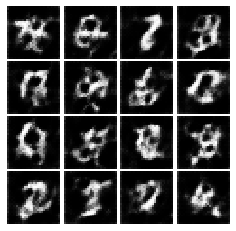

iteration: 234 - D_loss: -74.40110778808594 - G_loss: 3.0906703614164144e-06
epoch 65


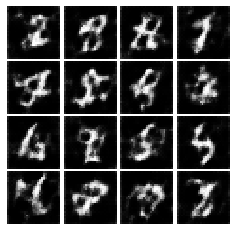

iteration: 234 - D_loss: -72.64249420166016 - G_loss: 0.17188523709774017
epoch 66


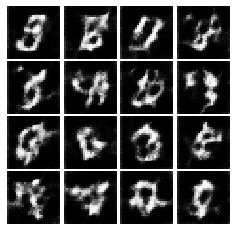

iteration: 234 - D_loss: -72.728759765625 - G_loss: 0.00011020756210200489
epoch 67


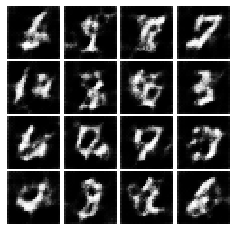

iteration: 234 - D_loss: -72.87468719482422 - G_loss: 0.0007651043124496937
epoch 68


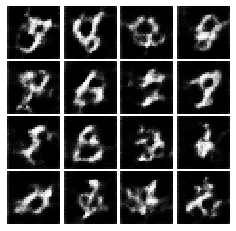

iteration: 234 - D_loss: -75.11308288574219 - G_loss: 0.1705043464899063
epoch 69


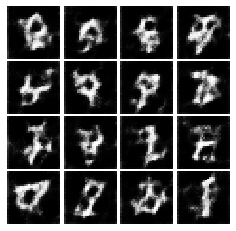

iteration: 234 - D_loss: -71.95171356201172 - G_loss: 0.13352222740650177
epoch 70


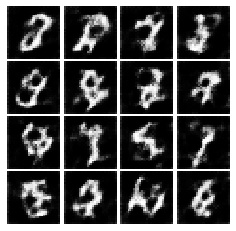

iteration: 234 - D_loss: -72.24855041503906 - G_loss: 0.008335521444678307
epoch 71


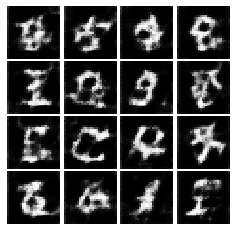

iteration: 234 - D_loss: -72.52739715576172 - G_loss: 0.016128312796354294
epoch 72


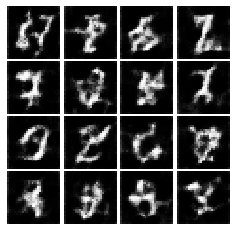

iteration: 234 - D_loss: -79.15201568603516 - G_loss: 0.4566960632801056
epoch 73


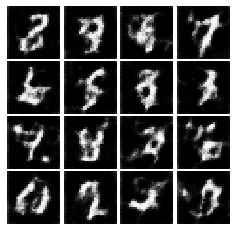

iteration: 234 - D_loss: -65.53689575195312 - G_loss: 0.010837497189640999
epoch 74


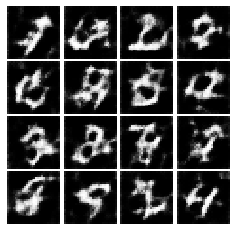

iteration: 234 - D_loss: -70.93307495117188 - G_loss: 0.060522232204675674
epoch 75


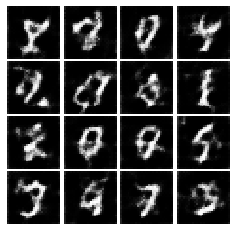

iteration: 234 - D_loss: -73.17135620117188 - G_loss: 0.00017671065870672464
epoch 76


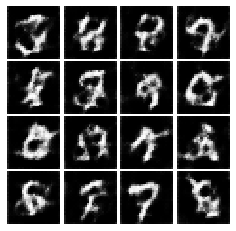

iteration: 234 - D_loss: -60.991825103759766 - G_loss: 5.652153049595654e-06
epoch 77


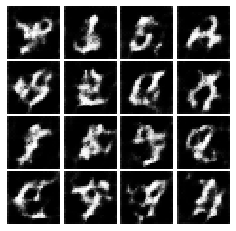

iteration: 234 - D_loss: -67.76222229003906 - G_loss: 5.871006942470558e-05
epoch 78


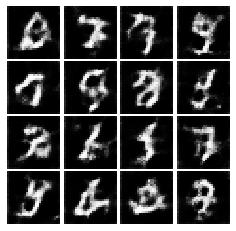

iteration: 234 - D_loss: -65.97343444824219 - G_loss: 0.00887981429696083
epoch 79


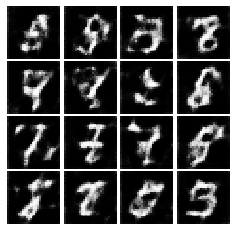

iteration: 234 - D_loss: -76.13668060302734 - G_loss: 0.016186876222491264
epoch 80


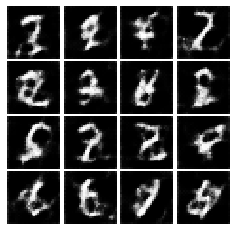

iteration: 234 - D_loss: -64.13062286376953 - G_loss: 0.03137551620602608
epoch 81


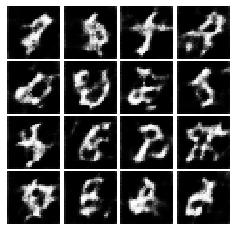

iteration: 234 - D_loss: -56.03318786621094 - G_loss: 0.004010679200291634
epoch 82


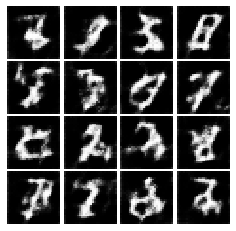

iteration: 234 - D_loss: -65.64666748046875 - G_loss: 0.14813227951526642
epoch 83


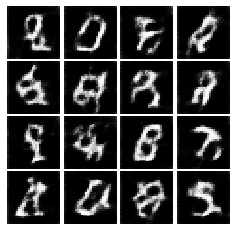

iteration: 234 - D_loss: -61.88996887207031 - G_loss: 0.800523042678833
epoch 84


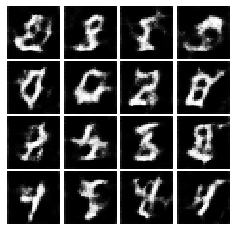

iteration: 234 - D_loss: -70.27876281738281 - G_loss: 0.07878319174051285
epoch 85


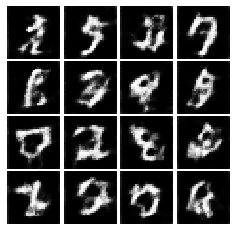

iteration: 234 - D_loss: -67.388427734375 - G_loss: 1.2331547623034567e-05
epoch 86


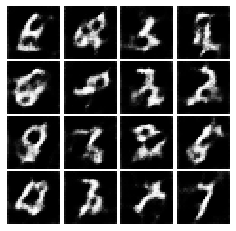

iteration: 234 - D_loss: -61.266292572021484 - G_loss: 0.04113258793950081
epoch 87


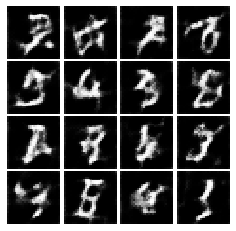

iteration: 234 - D_loss: -61.5168571472168 - G_loss: 0.47117289900779724
epoch 88


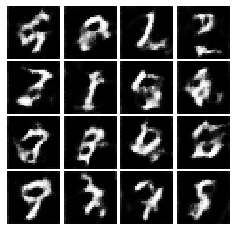

iteration: 234 - D_loss: -61.47455978393555 - G_loss: 0.15947231650352478
epoch 89


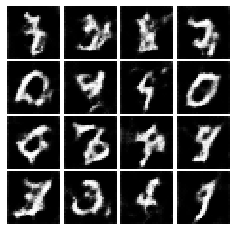

iteration: 234 - D_loss: -56.48209762573242 - G_loss: 0.10120096057653427
epoch 90


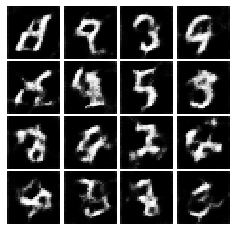

iteration: 234 - D_loss: -63.01654052734375 - G_loss: 1.4684139387100004e-05
epoch 91


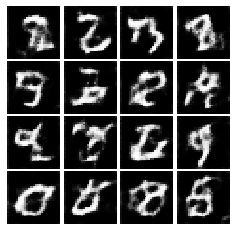

iteration: 234 - D_loss: -64.68978881835938 - G_loss: 0.010934708639979362
epoch 92


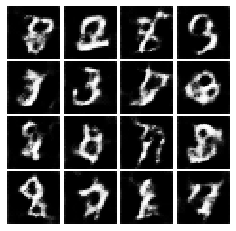

iteration: 234 - D_loss: -61.619075775146484 - G_loss: 0.07372070848941803
epoch 93


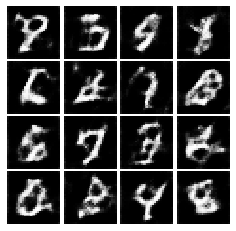

iteration: 234 - D_loss: -57.33051300048828 - G_loss: 0.26151469349861145
epoch 94


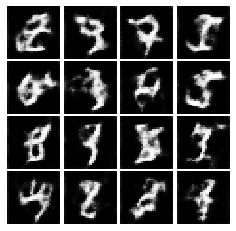

iteration: 234 - D_loss: -65.32108306884766 - G_loss: 0.16477850079536438
epoch 95


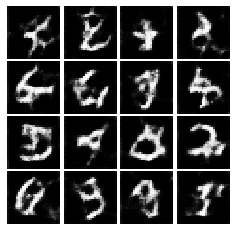

iteration: 234 - D_loss: -59.593997955322266 - G_loss: 0.013677715323865414
epoch 96


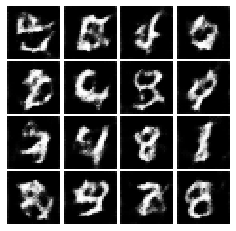

iteration: 234 - D_loss: -61.69634246826172 - G_loss: 0.3116838335990906
epoch 97


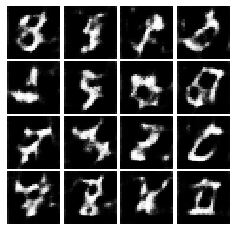

iteration: 234 - D_loss: -67.12249755859375 - G_loss: 9.445018076803535e-05
epoch 98


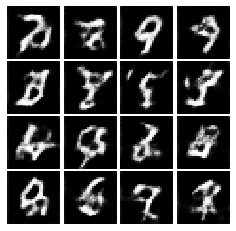

iteration: 234 - D_loss: -62.21538543701172 - G_loss: 0.7964321970939636
epoch 99


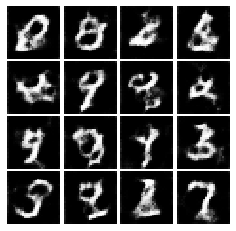

iteration: 234 - D_loss: -61.03981018066406 - G_loss: 0.05056598782539368
epoch 100


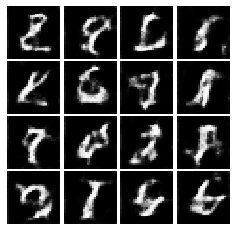

iteration: 234 - D_loss: -64.095703125 - G_loss: 0.00043914307025261223
Final Image:


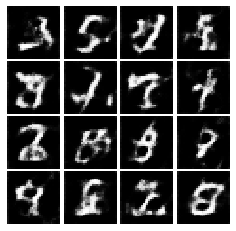

In [40]:
def show_samples(sess):
  samples = sess.run(fake_images)
  show_images(samples[:16])
  
def sample_noise(batch_size):
  return np.random.uniform(size=(batch_size, 1, 1, 1))

def on_epoch(sess):
  mnist = MNIST(batch_size=batch_size, shuffle=True)
  iter_counter = 1
  for (X, _) in mnist:
    if X.shape[0] != 256:
      continue
      
    D_loss_value, G_loss_value = None, None
    if iter_counter == 0 or iter_counter % 6 != 0:
      _, _D_loss = sess.run([D_train_step, D_loss], \
                            feed_dict={real_images: X, \
                                       alpha: sample_noise(X.shape[0])})

    else:    
      _, _G_loss = sess.run([G_train_step, G_loss], \
                            feed_dict={real_images: X, \
                                       alpha: sample_noise(X.shape[0])})
      
      print('\riteration: {} - D_loss: {} - G_loss: {}' \
            .format(iter_counter, _D_loss, _G_loss), end='')

    iter_counter += 1

  print('')
  return iter_counter


if not os.path.exists(CHECKPOINTS_DIR):
  os.makedirs(CHECKPOINTS_DIR)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  saver = tf.train.Saver(var_list=D_vars + G_vars,
                         save_relative_paths=True)
  
  for epoch in range(epoch_count):
    print('epoch {}'.format(epoch + 1)) 

    # Calculate Samples
    show_samples(sess)
    
    # epoch iterations
    iterations = on_epoch(sess)

    # save checkpoints
    saver.save(sess, '{}/dcgan'.format(CHECKPOINTS_DIR),
           global_step=(epoch+1) * iterations)

  
  
  print("Final Image:")
  # Calculate Samples
  show_samples(sess)


